In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

import copy
import random
import time

In [6]:
import zipfile
import os

In [8]:
!mkdir "data"
!mkdir "data/histopathologic-cancer-detection"

mkdir: data: File exists
mkdir: data/histopathologic-cancer-detection: File exists


In [9]:
zip_path = 'histopathologic-cancer-detection.zip'
extract_path = 'data/histopathologic-cancer-detection'  # Optional: Specify a target directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)  # Extracts to the specified path


In [7]:
ROOT = 'data'

In [8]:
split_ratio = 0.8
data_dir = os.path.join(ROOT, 'histopathologic-cancer-detection')
#images_dir = os.path.join(data_dir,'image')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# if os.path.exists(train_dir):
#     shutil.rmtree(train_dir)
# if os.path.exists(test_dir):
#     shutil.rmtree(test_dir)
#classes = os.listdir(images)


In [9]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [10]:
class ImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        if(csv_path != None):
            self.labels_df = pd.read_csv(csv_path) if csv_path else None
            self.sz =  len(self.labels_df)
        else:
            self.labels_df = None
            self.sz = len(os.listdir(img_dir))
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        #filename is the id in the cvs
        filename = self.labels_df.iloc[idx]['id']+".tif"
        label = self.labels_df.iloc[idx]['label']

        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
train_data = ImageDataset(csv_path = 'data/histopathologic-cancer-detection/train_labels.csv',
                              img_dir='data/histopathologic-cancer-detection/train',
                              transform=transforms.ToTensor())


EDA

In [12]:
ROOT = "data"
data_dir = os.path.join(ROOT, 'histopathologic-cancer-detection')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [13]:
img1, label1 = train_data[0]

In [14]:
label1

np.int64(0)

In [ ]:
means = torch.zeros(3)
stds = torch.zeros(3)
for img, label in train_data:
    means += torch.mean(img, dim = (1, 2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

In [16]:
pre_mean, pre_stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
pre_size = 224
train_transforms = transforms.Compose([
                           transforms.Resize(pre_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pre_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pre_mean, 
                                                std = pre_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pre_size),
                           transforms.CenterCrop(pre_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pre_mean, 
                                                std = pre_stds)
                       ])

In [17]:
p = "data/histopathologic-cancer-detection/train_labels.csv"
p1 = pd.read_csv(p)
p1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [18]:
train_data = ImageDataset(csv_path = 'data/histopathologic-cancer-detection/train_labels.csv',
                              img_dir='data/histopathologic-cancer-detection/train',
                              transform=train_transforms)
test_data = ImageDataset(csv_path = None,
                              img_dir='data/histopathologic-cancer-detection/test',
                              transform=test_transforms)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [19]:
train_valid_ratio = 0.9
train_size = int(train_valid_ratio * len(train_data))
val_size = len(train_data) - train_size
train_size, val_size, len(test_data)

(198022, 22003, 57458)

In [20]:
train_data, valid_data = data.random_split(train_data, [train_size, val_size])

In [21]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [27]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 198022
Number of validation examples: 22003
Number of testing examples: 57458


Number of training examples: 178219
Number of validation examples: 19803
Number of testing examples: 57458

In [28]:
# # clearn up the memoryu
# torch.mps.empty_cache()

In [29]:
BATCH_SIZE = 256
train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [30]:
import matplotlib.pyplot as plt

In [31]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image   
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

In [32]:
import matplotlib.pyplot as plt

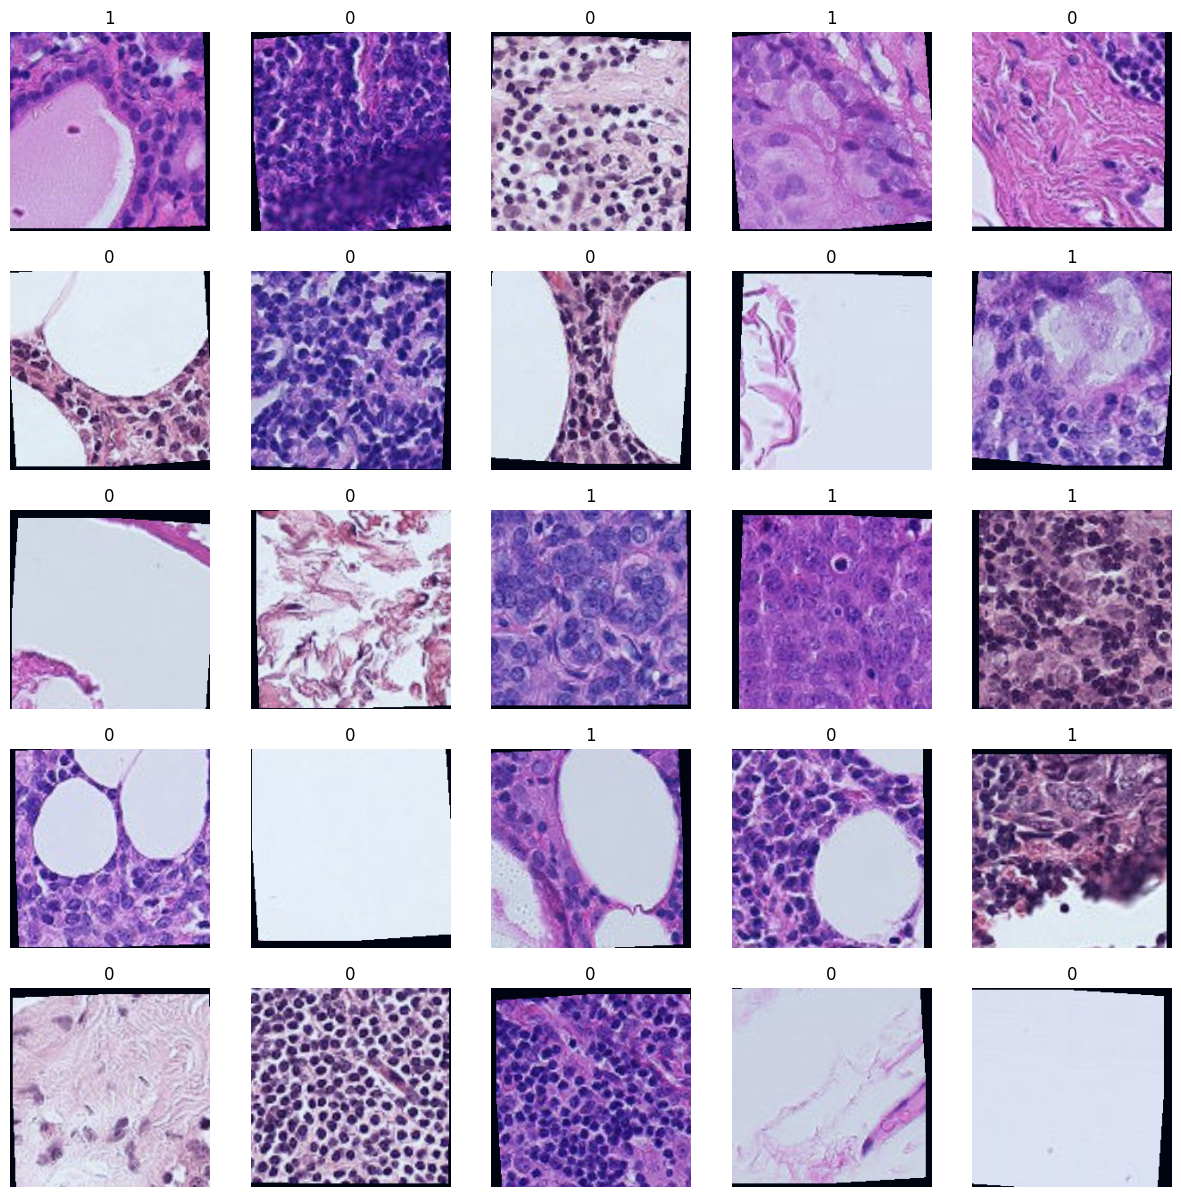

In [35]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = [0,1]

plot_images(images, labels, classes)

In [36]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [33]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [34]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)
        return x

In [35]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [36]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [37]:
512/32

16.0

In [38]:
from collections import namedtuple
ResNetConfig = namedtuple('ResNetConfig',['block', 'n_blocks', 'channels'])

In [39]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

In [44]:
m_trained = models.resnet50(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
in_dim = m_trained.fc.in_features
out_dim = 2
fc = nn.Linear(in_dim, out_dim)

In [46]:
m_trained.fc = fc

In [47]:
model = ResNet(resnet50_config, out_dim)
model.load_state_dict(m_trained.state_dict())

<All keys matched successfully>

In [40]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])
m_trained = models.resnet18(pretrained=True)
in_dim = m_trained.fc.in_features
out_dim = 2
fc = nn.Linear(in_dim, out_dim)
m_trained.fc = fc
model = ResNet(resnet18_config, out_dim)
model.load_state_dict(m_trained.state_dict())

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,177,538 trainable parameters


In [42]:
Start_LR = 1e-7
optimizer = optim.Adam(model.parameters(), lr=Start_LR)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [43]:
with torch.no_grad():
    torch.mps.empty_cache()

In [44]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs ]
    
class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)
    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)
        return inputs, labels
    def get_batch(self):
        return next(self)

In [45]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [46]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs ]
    
class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)
    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)
        return inputs, labels
    def get_batch(self):
        return next(self)

In [47]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [48]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [ ]:
end_lr = 10
num_iter=100
lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, end_lr, num_iter)

In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end=5):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start: -skip_end]
    
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both','x')
    plt.show()

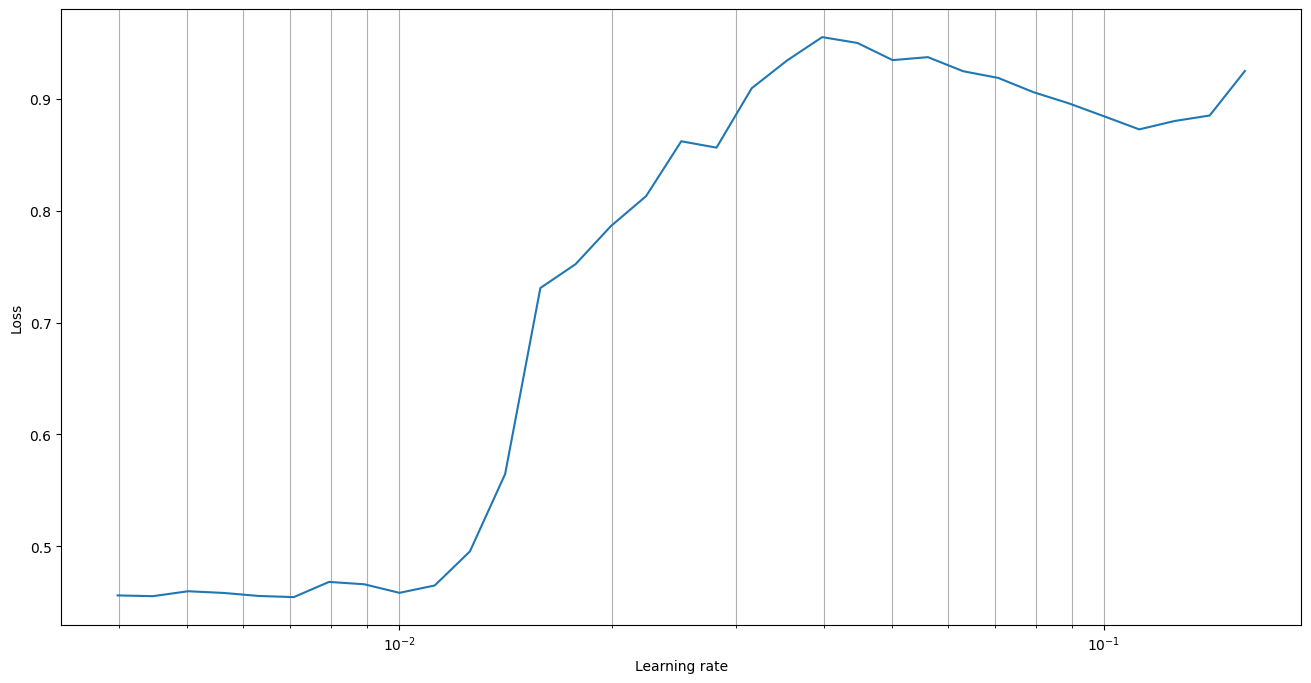

In [87]:
plot_lr_finder(lrs, losses, skip_start=30, skip_end=30)

In [88]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [89]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [90]:
len(train_iterator)

774

In [91]:
EPOCHS

10

In [92]:
EPOCHS * STEPS_PER_EPOCH

7740

In [93]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [94]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        #acc_1, acc_5 = calculate_topk_accuracy(y_pred, y, k=1)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        # epoch_acc_1 += acc_1.item()
        # epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss

In [51]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            #acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            #epoch_acc_1 += acc_1.item()
            #epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss

In [96]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [97]:
device

device(type='mps')

In [98]:
import time
import torch

device = "mps"

torch.manual_seed(1234)
TENSOR_A_CPU = torch.rand(5000, 5000)
TENSOR_B_CPU = torch.rand(5000, 5000)

torch.manual_seed(1234)
TENSOR_A_MPS = torch.rand(5000, 5000).to(device)
TENSOR_B_MPS = torch.rand(5000, 5000).to(device)

# Warm-up
for _ in range(100):
    torch.matmul(torch.rand(500,500).to(device), torch.rand(500,500).to(device))
    
start_time = time.time()
torch.matmul(TENSOR_A_CPU, TENSOR_B_CPU)
print("CPU : --- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
torch.matmul(TENSOR_A_MPS, TENSOR_B_MPS)
print("MPS : --- %s seconds ---" % (time.time() - start_time))

CPU : --- 0.09370112419128418 seconds ---
MPS : --- 0.00026679039001464844 seconds ---


In [99]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValid Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 11m 34s
	Train Loss: 0.222
	Valid Loss: 0.140
Epoch: 02 | Epoch Time: 11m 46s
	Train Loss: 0.135
	Valid Loss: 0.125
Epoch: 03 | Epoch Time: 11m 56s
	Train Loss: 0.108
	Valid Loss: 0.114
Epoch: 04 | Epoch Time: 11m 54s
	Train Loss: 0.090
	Valid Loss: 0.086
Epoch: 05 | Epoch Time: 13m 20s
	Train Loss: 0.076
	Valid Loss: 0.093
Epoch: 06 | Epoch Time: 13m 15s
	Train Loss: 0.062
	Valid Loss: 0.069
Epoch: 07 | Epoch Time: 13m 6s
	Train Loss: 0.047
	Valid Loss: 0.063
Epoch: 08 | Epoch Time: 12m 32s
	Train Loss: 0.032
	Valid Loss: 0.055
Epoch: 09 | Epoch Time: 11m 49s
	Train Loss: 0.021
	Valid Loss: 0.053
Epoch: 10 | Epoch Time: 11m 36s
	Train Loss: 0.015
	Valid Loss: 0.053


In [53]:
model.load_state_dict(torch.load('tut5-model.pt'))

<All keys matched successfully>

In [54]:
def acc_validation(model, iterator, criterion, device):
    
    loss_valid, acc = 0, 0
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)
            
            bz = y_pred.shape[0]
            loss = criterion(y_pred, y)
            out = torch.argmax(y_pred, dim=-1)
            loss_valid += loss.item()
            acc += (out == y).sum().item()/bz



            # if(acc!=1.0):
            #     print("batch_size: ",bz)
            #     print("acc: ",(out == y).sum().item())
            #     break

    loss_valid /= len(iterator)
    print("acc: ",acc)
    print("len(iterator): ",len(iterator))
    acc /= len(iterator)
        
    return loss_valid, acc

In [ ]:
model.load_state_dict(torch.load('tut5-model.pt'))
    
valid_loss, acc = acc_validation(model, valid_iterator, criterion, device)

print(f'valid Loss: {valid_loss:.3f} | Acc @1: {acc*100:6.2f}%')

acc:  85.66775977366255
len(iterator):  86
Test Loss: 0.013 | Acc @1:  99.61%
